In [4]:
import os, random, math, time, json
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import ViTModel, ViTConfig
from transformers.models.vit.modeling_vit import ViTSelfAttention
from torch.optim.lr_scheduler import CosineAnnealingLR

# =====================================================
# CONFIG
# =====================================================
class CFG:
    data_root   = r"F:\NeuTech\CWT"            # <-- your CWT root with class subfolders
    output_dir  = r"F:\NeuTech\new_results"     # <-- where to save outputs
    model_name  = "google/vit-base-patch16-224-in21k"
    seed        = 42
    batch_size  = 16
    num_workers = 0          # Windows-friendly
    pin_memory  = False
    lr          = 3e-4
    weight_decay = 1e-4
    epochs      = 50
    val_split   = 0.2
    device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = CFG()
os.makedirs(cfg.output_dir, exist_ok=True)
random.seed(cfg.seed)
torch.manual_seed(cfg.seed)

# =====================================================
# TRANSFORMS (ViT expects 3×224×224 normalized around 0.5)
# =====================================================
tf_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
tf_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# =====================================================
# DATASET + STRATIFIED SPLIT
# =====================================================
base = ImageFolder(root=cfg.data_root)  # only to read labels/paths
class_to_indices = {}
for idx, (_, y) in enumerate(base.samples):
    class_to_indices.setdefault(y, []).append(idx)

train_idx, val_idx = [], []
for y, idxs in class_to_indices.items():
    random.shuffle(idxs)
    n_val = max(1, int(round(len(idxs) * cfg.val_split)))
    val_idx += idxs[:n_val]
    train_idx += idxs[n_val:]
random.shuffle(train_idx); random.shuffle(val_idx)

full_train = ImageFolder(root=cfg.data_root, transform=tf_train)
full_val   = ImageFolder(root=cfg.data_root, transform=tf_val)
train_dataset = Subset(full_train, train_idx)
val_dataset   = Subset(full_val,   val_idx)

def collate_fn_preprocessed(batch):
    images, labels = zip(*batch)
    x = torch.stack([im for im in images]).float()   # PIL→tensor done in transform
    # Ensure 3 channels (CWT PNGs are usually RGB already)
    if x.ndim == 4 and x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    y = torch.tensor(labels, dtype=torch.long)
    return {"pixel_values": x, "labels": y}

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                          collate_fn=collate_fn_preprocessed,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
val_loader   = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False,
                          collate_fn=collate_fn_preprocessed,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print("Classes:", full_train.classes)

# =====================================================
# PHYSICS-AWARE ATTENTION
# =====================================================
class BandAwareAttention(ViTSelfAttention):
    """
    ViT attention + learnable frequency-band bias.
    Expects band_ids shaped [B, seq_len], where seq_len = 1+num_patches (CLS included).
    """
    def __init__(self, config, num_bands=5):
        super().__init__(config)
        self.band_rel_bias = nn.Parameter(torch.zeros(num_bands, num_bands))
        nn.init.xavier_uniform_(self.band_rel_bias)
        self.band_dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, band_ids=None, **kwargs):
        bsz, seq_len, _ = hidden_states.shape

        query = self.transpose_for_scores(self.query(hidden_states))
        key   = self.transpose_for_scores(self.key(hidden_states))
        value = self.transpose_for_scores(self.value(hidden_states))

        attn_scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.attention_head_size)

        # Add learnable band bias
        if band_ids is not None:
            # band_ids: [B, seq_len], values in [0..num_bands-1]
            if band_ids.dim() == 1:
                band_ids = band_ids.unsqueeze(0).repeat(bsz, 1)
            # bias per (query_token, key_token)
            band_bias = self.band_rel_bias[band_ids][:, :, band_ids]  # [B, seq_len, seq_len]
            band_bias = band_bias.unsqueeze(1)                        # [B, 1, seq_len, seq_len]
            attn_scores = attn_scores + band_bias

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.band_dropout(attn_probs)

        context = torch.matmul(attn_probs, value)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_context = context.view(bsz, seq_len, self.all_head_size)
        return new_context, attn_probs

class PhysicsAwareViT(nn.Module):
    def __init__(self, cfg, num_classes, num_bands=5):
        super().__init__()
        vit_cfg = ViTConfig.from_pretrained(cfg.model_name)
        vit_cfg.num_labels = num_classes
        self.vit = ViTModel.from_pretrained(cfg.model_name, config=vit_cfg)
        self.hidden = vit_cfg.hidden_size
        self.num_bands = num_bands

        # Replace attention with band-aware attention
        for blk in self.vit.encoder.layer:
            blk.attention.attention = BandAwareAttention(vit_cfg, num_bands=num_bands)

        self.band_embed = nn.Embedding(num_bands, self.hidden)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.hidden),
            nn.Linear(self.hidden, num_classes)
        )

        # cache patch/token sizes
        self.image_size = vit_cfg.image_size
        self.patch_size = vit_cfg.patch_size
        self.num_patches = (self.image_size // self.patch_size) ** 2     # 224/16 → 14×14 = 196
        self.seq_len = self.num_patches + 1                              # + CLS = 197

    def forward(self, pixel_values, labels=None, band_ids=None):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        cls_emb = outputs.last_hidden_state[:, 0]

        if band_ids is not None:
            # band embedding pooled over sequence (simple variant)
            band_emb = self.band_embed(band_ids)                   # [B, seq_len, H]
            cls_emb = cls_emb + band_emb.mean(dim=1)

        logits = self.mlp_head(cls_emb)
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# =====================================================
# UTILITIES
# =====================================================
def generate_band_ids(batch_size, seq_len, num_bands=5):
    """
    Make band ids for full token sequence (CLS + patches).
    We give CLS token band 0, and tile bands across the 196 patches.
    """
    n_patches = seq_len - 1                    # e.g., 196
    patch_ids = torch.arange(n_patches) % num_bands
    full = torch.zeros(seq_len, dtype=torch.long)
    full[1:] = patch_ids
    return full.unsqueeze(0).repeat(batch_size, 1)  # [B, seq_len]

def accuracy_fn(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, total_acc, steps = 0.0, 0.0, 0
    for batch in loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        band_ids = generate_band_ids(pixel_values.size(0), model.seq_len, model.num_bands).to(device)
        out = model(pixel_values=pixel_values, labels=labels, band_ids=band_ids)
        total_loss += out["loss"].item()
        total_acc  += accuracy_fn(out["logits"], labels)
        steps += 1
    return total_loss / steps, total_acc / steps

# =====================================================
# TRAINING
# =====================================================
model = PhysicsAwareViT(cfg, num_classes=len(full_train.classes)).to(cfg.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs)
scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device.type == "cuda"))

best_acc = 0.0
best_ckpt = os.path.join(cfg.output_dir, "best_model.pt")

for epoch in range(1, cfg.epochs + 1):
    model.train()
    epoch_loss, epoch_acc, steps = 0.0, 0.0, 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}", leave=False)
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(cfg.device)
        labels = batch["labels"].to(cfg.device)
        band_ids = generate_band_ids(pixel_values.size(0), model.seq_len, model.num_bands).to(cfg.device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(cfg.device.type == "cuda")):
            out = model(pixel_values=pixel_values, labels=labels, band_ids=band_ids)
            loss = out["loss"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        acc = accuracy_fn(out["logits"].detach(), labels)
        epoch_loss += loss.item(); epoch_acc += acc; steps += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}")

    val_loss, val_acc = evaluate(model, val_loader, cfg.device)
    dt = time.time() - t0
    print(f"[{epoch:03d}] train_loss={epoch_loss/steps:.4f}, train_acc={epoch_acc/steps:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, time={dt:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": val_acc,
            "classes": full_train.classes,
            "cfg": vars(cfg),
        }, best_ckpt)
        print(f"  ✅ New best model saved with val_acc={val_acc:.4f}")

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

# =====================================================
# EVALUATION + CONFUSION MATRIX
# =====================================================
# (Re)load best model for clean evaluation
checkpoint = torch.load(best_ckpt, map_location=cfg.device)
model.load_state_dict(checkpoint["model_state"])
model.eval()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        x = batch["pixel_values"].to(cfg.device)
        y = batch["labels"].to(cfg.device)
        band_ids = generate_band_ids(x.size(0), model.seq_len, model.num_bands).to(cfg.device)
        out = model(pixel_values=x, labels=None, band_ids=band_ids)["logits"]
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_train.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_train.classes, yticklabels=full_train.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
cm_path = os.path.join(cfg.output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=400)
plt.close()
print(f"✅ Confusion matrix saved at: {cm_path}")


Train samples: 1536, Val samples: 384
Classes: ['ball', 'healthy', 'inner', 'outer']


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_3068\845332510.py:211: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device.type == "cuda"))
Epoch 1/50:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_3068\845332510.py:228: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.device.type == "cuda")):


[001] train_loss=1.3258, train_acc=0.4277, val_loss=1.3038, val_acc=0.4375, time=503.0s
  ✅ New best model saved with val_acc=0.4375


[002] train_loss=1.3063, train_acc=0.4375, val_loss=1.3030, val_acc=0.4375, time=503.1s


[003] train_loss=1.3081, train_acc=0.4375, val_loss=1.3187, val_acc=0.4375, time=501.2s


[004] train_loss=1.3157, train_acc=0.4206, val_loss=1.3062, val_acc=0.4375, time=499.3s


[005] train_loss=1.2750, train_acc=0.4395, val_loss=1.2561, val_acc=0.3333, time=512.0s


[006] train_loss=1.0724, train_acc=0.5397, val_loss=0.9913, val_acc=0.5703, time=507.5s
  ✅ New best model saved with val_acc=0.5703


[007] train_loss=0.9458, train_acc=0.5911, val_loss=0.8498, val_acc=0.6510, time=504.0s
  ✅ New best model saved with val_acc=0.6510


[008] train_loss=0.8582, train_acc=0.6296, val_loss=0.7806, val_acc=0.6536, time=504.9s
  ✅ New best model saved with val_acc=0.6536


[009] train_loss=0.7284, train_acc=0.6895, val_loss=0.6318, val_acc=0.7318, time=500.4s
  ✅ New best model saved with val_acc=0.7318


[010] train_loss=0.6473, train_acc=0.7155, val_loss=0.5597, val_acc=0.7578, time=484.4s
  ✅ New best model saved with val_acc=0.7578


[011] train_loss=0.6347, train_acc=0.7253, val_loss=0.5760, val_acc=0.7604, time=492.5s
  ✅ New best model saved with val_acc=0.7604


[012] train_loss=0.5611, train_acc=0.7663, val_loss=0.4763, val_acc=0.8047, time=500.5s
  ✅ New best model saved with val_acc=0.8047


[013] train_loss=0.6123, train_acc=0.7513, val_loss=0.7537, val_acc=0.7057, time=507.7s


[014] train_loss=0.5798, train_acc=0.7669, val_loss=0.4821, val_acc=0.7865, time=482.9s


[015] train_loss=0.6628, train_acc=0.7331, val_loss=0.8711, val_acc=0.6354, time=481.1s


[016] train_loss=0.6954, train_acc=0.7148, val_loss=0.4969, val_acc=0.7891, time=488.3s


[017] train_loss=0.4941, train_acc=0.8034, val_loss=0.5306, val_acc=0.8021, time=493.1s


[018] train_loss=0.4262, train_acc=0.8398, val_loss=0.4600, val_acc=0.8333, time=491.4s
  ✅ New best model saved with val_acc=0.8333


[019] train_loss=0.4013, train_acc=0.8431, val_loss=0.3870, val_acc=0.8516, time=491.6s
  ✅ New best model saved with val_acc=0.8516


[020] train_loss=0.3323, train_acc=0.8737, val_loss=0.6463, val_acc=0.7318, time=498.9s


[021] train_loss=0.3619, train_acc=0.8626, val_loss=0.4884, val_acc=0.8151, time=492.1s


[022] train_loss=0.2808, train_acc=0.8919, val_loss=0.4210, val_acc=0.8464, time=501.7s


[023] train_loss=0.2410, train_acc=0.9076, val_loss=0.3916, val_acc=0.8359, time=499.7s


[024] train_loss=0.1988, train_acc=0.9167, val_loss=0.3476, val_acc=0.8672, time=495.3s
  ✅ New best model saved with val_acc=0.8672


[025] train_loss=0.1954, train_acc=0.9277, val_loss=0.3121, val_acc=0.8802, time=494.8s
  ✅ New best model saved with val_acc=0.8802


[026] train_loss=0.1903, train_acc=0.9290, val_loss=0.3996, val_acc=0.8411, time=502.6s


[027] train_loss=0.1576, train_acc=0.9342, val_loss=0.4624, val_acc=0.8255, time=508.3s


[028] train_loss=0.1625, train_acc=0.9395, val_loss=0.2573, val_acc=0.8984, time=503.3s
  ✅ New best model saved with val_acc=0.8984


[029] train_loss=0.0844, train_acc=0.9688, val_loss=0.2019, val_acc=0.9349, time=505.1s
  ✅ New best model saved with val_acc=0.9349


[030] train_loss=0.1546, train_acc=0.9453, val_loss=0.2648, val_acc=0.9193, time=499.0s


[031] train_loss=0.1083, train_acc=0.9603, val_loss=0.1855, val_acc=0.9375, time=502.8s
  ✅ New best model saved with val_acc=0.9375


[032] train_loss=0.0387, train_acc=0.9889, val_loss=0.2028, val_acc=0.9453, time=505.5s
  ✅ New best model saved with val_acc=0.9453


[033] train_loss=0.1303, train_acc=0.9551, val_loss=0.2480, val_acc=0.9193, time=508.2s


[034] train_loss=0.1233, train_acc=0.9577, val_loss=0.2175, val_acc=0.9167, time=508.7s


[035] train_loss=0.0422, train_acc=0.9883, val_loss=0.2010, val_acc=0.9427, time=511.5s


[036] train_loss=0.0177, train_acc=0.9948, val_loss=0.2600, val_acc=0.9349, time=513.2s


[037] train_loss=0.1177, train_acc=0.9590, val_loss=0.1727, val_acc=0.9375, time=505.3s


[038] train_loss=0.1154, train_acc=0.9616, val_loss=0.2217, val_acc=0.9193, time=500.9s


[039] train_loss=0.0773, train_acc=0.9733, val_loss=0.1931, val_acc=0.9297, time=500.0s


[040] train_loss=0.0149, train_acc=0.9967, val_loss=0.2221, val_acc=0.9557, time=505.6s
  ✅ New best model saved with val_acc=0.9557


[041] train_loss=0.0748, train_acc=0.9785, val_loss=0.2908, val_acc=0.8984, time=511.2s


[042] train_loss=0.0607, train_acc=0.9798, val_loss=0.2256, val_acc=0.9479, time=519.7s


[043] train_loss=0.0561, train_acc=0.9792, val_loss=0.3172, val_acc=0.9062, time=507.1s


[044] train_loss=0.0271, train_acc=0.9915, val_loss=0.1898, val_acc=0.9453, time=504.2s


[045] train_loss=0.0367, train_acc=0.9896, val_loss=0.4225, val_acc=0.8906, time=512.0s


[046] train_loss=0.0467, train_acc=0.9818, val_loss=0.4374, val_acc=0.8984, time=507.0s


[047] train_loss=0.0297, train_acc=0.9935, val_loss=0.2516, val_acc=0.9453, time=502.6s


[048] train_loss=0.0016, train_acc=1.0000, val_loss=0.1640, val_acc=0.9505, time=519.9s


[049] train_loss=0.0007, train_acc=1.0000, val_loss=0.1904, val_acc=0.9505, time=531.9s


[050] train_loss=0.0005, train_acc=1.0000, val_loss=0.1907, val_acc=0.9479, time=519.7s
Training complete. Best validation accuracy: 0.9557
✅ Validation Accuracy: 95.57%

Classification Report:
              precision    recall  f1-score   support

        ball       0.97      0.94      0.96        80
     healthy       1.00      1.00      1.00        56
       inner       0.92      0.89      0.90        80
       outer       0.95      0.98      0.96       168

    accuracy                           0.96       384
   macro avg       0.96      0.95      0.96       384
weighted avg       0.96      0.96      0.96       384

✅ Confusion matrix saved at: F:\NeuTech\new_results\confusion_matrix.png


In [ ]:
let

✅ Balanced dataset created at: F:\NeuTech\CWT_balanced
Train samples: 1003, Val samples: 177
Classes: ['ball', 'healthy', 'inner', 'outer']


[001] train_loss=1.4122, train_acc=0.2477, val_loss=1.3853, val_acc=0.3261, time=350.9s
  ✅ New best model saved with val_acc=0.3261


[002] train_loss=1.3172, train_acc=0.3168, val_loss=1.0471, val_acc=0.4783, time=420.8s
  ✅ New best model saved with val_acc=0.4783


[003] train_loss=1.1134, train_acc=0.4345, val_loss=0.9700, val_acc=0.4293, time=362.8s


[004] train_loss=1.0248, train_acc=0.4709, val_loss=1.0808, val_acc=0.4565, time=436.4s


[005] train_loss=1.0773, train_acc=0.4461, val_loss=0.9911, val_acc=0.4293, time=343.1s


[006] train_loss=1.0006, train_acc=0.4897, val_loss=0.8759, val_acc=0.5707, time=375.2s
  ✅ New best model saved with val_acc=0.5707


[007] train_loss=0.9874, train_acc=0.4831, val_loss=0.9438, val_acc=0.5598, time=368.2s


[008] train_loss=0.9310, train_acc=0.5304, val_loss=0.8577, val_acc=0.5815, time=356.2s
  ✅ New best model saved with val_acc=0.5815


[009] train_loss=0.8727, train_acc=0.5866, val_loss=1.0655, val_acc=0.4402, time=333.6s


[010] train_loss=1.0231, train_acc=0.4587, val_loss=0.9772, val_acc=0.4402, time=379.4s


[011] train_loss=0.9712, train_acc=0.4735, val_loss=0.8923, val_acc=0.5000, time=353.4s


[012] train_loss=0.9680, train_acc=0.4891, val_loss=0.8627, val_acc=0.5978, time=357.0s
  ✅ New best model saved with val_acc=0.5978


[013] train_loss=0.9076, train_acc=0.5360, val_loss=0.9243, val_acc=0.4674, time=400.2s


[014] train_loss=0.8989, train_acc=0.5612, val_loss=0.9177, val_acc=0.4891, time=374.8s


[015] train_loss=0.8230, train_acc=0.5982, val_loss=0.7222, val_acc=0.6141, time=333.6s
  ✅ New best model saved with val_acc=0.6141


[016] train_loss=0.7859, train_acc=0.6204, val_loss=0.6402, val_acc=0.7011, time=329.4s
  ✅ New best model saved with val_acc=0.7011


[017] train_loss=0.7844, train_acc=0.6214, val_loss=0.6433, val_acc=0.6413, time=324.6s


[018] train_loss=0.7955, train_acc=0.6561, val_loss=0.7878, val_acc=0.5707, time=327.4s


[019] train_loss=0.7341, train_acc=0.6594, val_loss=0.7240, val_acc=0.6467, time=324.2s


[020] train_loss=0.6613, train_acc=0.7067, val_loss=0.5456, val_acc=0.7609, time=332.0s
  ✅ New best model saved with val_acc=0.7609


[021] train_loss=0.6399, train_acc=0.7212, val_loss=0.4345, val_acc=0.8478, time=332.5s
  ✅ New best model saved with val_acc=0.8478


[022] train_loss=0.6209, train_acc=0.7126, val_loss=0.6114, val_acc=0.6957, time=327.9s


[023] train_loss=0.5857, train_acc=0.7464, val_loss=0.8090, val_acc=0.6196, time=331.7s


[024] train_loss=0.6434, train_acc=0.7100, val_loss=0.5974, val_acc=0.7391, time=329.0s


[025] train_loss=0.5629, train_acc=0.7540, val_loss=0.3972, val_acc=0.8315, time=326.3s


[026] train_loss=0.5235, train_acc=0.7728, val_loss=0.3138, val_acc=0.8641, time=324.5s
  ✅ New best model saved with val_acc=0.8641


[027] train_loss=0.4681, train_acc=0.8036, val_loss=0.4712, val_acc=0.8315, time=326.9s


[028] train_loss=0.4934, train_acc=0.7946, val_loss=0.5035, val_acc=0.8098, time=323.4s


[029] train_loss=0.4731, train_acc=0.7920, val_loss=0.5954, val_acc=0.7283, time=324.7s


[030] train_loss=0.4696, train_acc=0.8036, val_loss=0.3061, val_acc=0.8533, time=323.0s


[031] train_loss=0.4474, train_acc=0.8244, val_loss=0.2740, val_acc=0.8750, time=324.3s
  ✅ New best model saved with val_acc=0.8750


[032] train_loss=0.3915, train_acc=0.8366, val_loss=0.3160, val_acc=0.9022, time=324.0s
  ✅ New best model saved with val_acc=0.9022


[033] train_loss=0.3619, train_acc=0.8535, val_loss=0.3576, val_acc=0.8804, time=324.5s


[034] train_loss=0.3938, train_acc=0.8356, val_loss=0.2669, val_acc=0.8750, time=330.7s


[035] train_loss=0.4624, train_acc=0.8115, val_loss=0.3385, val_acc=0.8370, time=333.5s


[036] train_loss=0.4171, train_acc=0.8178, val_loss=0.2939, val_acc=0.8750, time=326.6s


[037] train_loss=0.3841, train_acc=0.8356, val_loss=0.3328, val_acc=0.8533, time=329.3s


[038] train_loss=0.3864, train_acc=0.8442, val_loss=0.3733, val_acc=0.8750, time=341.7s


[039] train_loss=0.3528, train_acc=0.8502, val_loss=0.2231, val_acc=0.9130, time=329.6s
  ✅ New best model saved with val_acc=0.9130


[040] train_loss=0.3363, train_acc=0.8601, val_loss=0.2525, val_acc=0.9022, time=334.1s


[041] train_loss=0.3193, train_acc=0.8803, val_loss=0.2692, val_acc=0.8967, time=339.4s


[042] train_loss=0.2962, train_acc=0.8810, val_loss=0.2415, val_acc=0.9076, time=361.9s


[043] train_loss=0.3258, train_acc=0.8813, val_loss=0.1823, val_acc=0.9293, time=340.5s
  ✅ New best model saved with val_acc=0.9293


[044] train_loss=0.3882, train_acc=0.8413, val_loss=0.2104, val_acc=0.9239, time=349.3s


[045] train_loss=0.2916, train_acc=0.8932, val_loss=0.1843, val_acc=0.9402, time=347.2s
  ✅ New best model saved with val_acc=0.9402


[046] train_loss=0.2598, train_acc=0.9077, val_loss=0.3881, val_acc=0.8370, time=367.7s


[047] train_loss=0.2665, train_acc=0.8968, val_loss=0.1798, val_acc=0.9239, time=343.9s


[048] train_loss=0.2623, train_acc=0.8972, val_loss=0.1759, val_acc=0.9457, time=343.3s
  ✅ New best model saved with val_acc=0.9457


[049] train_loss=0.4401, train_acc=0.8353, val_loss=0.2143, val_acc=0.9185, time=346.1s


[050] train_loss=0.3644, train_acc=0.8568, val_loss=0.1995, val_acc=0.9293, time=349.6s


[051] train_loss=0.3355, train_acc=0.8790, val_loss=0.2383, val_acc=0.9130, time=343.8s


[052] train_loss=0.2759, train_acc=0.8932, val_loss=0.2531, val_acc=0.9130, time=344.6s


[053] train_loss=0.2546, train_acc=0.9008, val_loss=0.1466, val_acc=0.9674, time=340.7s
  ✅ New best model saved with val_acc=0.9674


[054] train_loss=0.3015, train_acc=0.8829, val_loss=0.2279, val_acc=0.9239, time=343.3s


[055] train_loss=0.2801, train_acc=0.8899, val_loss=0.2280, val_acc=0.9130, time=347.6s


[056] train_loss=0.2523, train_acc=0.8952, val_loss=0.3714, val_acc=0.8804, time=358.6s


[057] train_loss=0.2422, train_acc=0.9107, val_loss=0.1263, val_acc=0.9728, time=343.6s
  ✅ New best model saved with val_acc=0.9728


[058] train_loss=0.2691, train_acc=0.9058, val_loss=0.1308, val_acc=0.9511, time=343.6s


[059] train_loss=0.2288, train_acc=0.9177, val_loss=0.0873, val_acc=0.9783, time=345.2s
  ✅ New best model saved with val_acc=0.9783


[060] train_loss=0.2361, train_acc=0.9087, val_loss=0.1290, val_acc=0.9457, time=343.2s


[061] train_loss=0.2042, train_acc=0.9309, val_loss=0.1940, val_acc=0.9348, time=344.5s


[062] train_loss=0.1932, train_acc=0.9335, val_loss=0.2113, val_acc=0.9293, time=340.4s


[063] train_loss=0.2470, train_acc=0.9038, val_loss=0.0969, val_acc=0.9402, time=340.1s


[064] train_loss=0.2435, train_acc=0.9071, val_loss=0.1294, val_acc=0.9674, time=338.5s


[065] train_loss=0.2123, train_acc=0.9216, val_loss=0.1611, val_acc=0.9293, time=350.3s


[066] train_loss=0.1722, train_acc=0.9365, val_loss=0.2472, val_acc=0.9022, time=350.4s


[067] train_loss=0.1988, train_acc=0.9325, val_loss=0.0853, val_acc=0.9728, time=347.4s


[068] train_loss=0.1719, train_acc=0.9398, val_loss=0.0838, val_acc=0.9728, time=347.1s


[069] train_loss=0.2256, train_acc=0.9190, val_loss=0.0914, val_acc=0.9783, time=345.0s


[070] train_loss=0.2134, train_acc=0.9233, val_loss=0.1986, val_acc=0.9185, time=344.7s


[071] train_loss=0.1759, train_acc=0.9325, val_loss=0.1389, val_acc=0.9620, time=344.8s


[072] train_loss=0.2005, train_acc=0.9365, val_loss=0.0822, val_acc=0.9674, time=342.3s


[073] train_loss=0.2013, train_acc=0.9226, val_loss=0.1128, val_acc=0.9674, time=343.3s


[074] train_loss=0.1864, train_acc=0.9226, val_loss=0.1327, val_acc=0.9620, time=343.2s


[075] train_loss=0.1524, train_acc=0.9514, val_loss=0.4783, val_acc=0.8424, time=344.2s


[076] train_loss=0.1719, train_acc=0.9425, val_loss=0.1360, val_acc=0.9457, time=372.9s


[077] train_loss=0.2136, train_acc=0.9236, val_loss=0.0773, val_acc=0.9728, time=367.1s


[078] train_loss=0.1907, train_acc=0.9385, val_loss=0.0540, val_acc=0.9891, time=345.4s
  ✅ New best model saved with val_acc=0.9891


[079] train_loss=0.1412, train_acc=0.9474, val_loss=0.1557, val_acc=0.9402, time=347.4s


[080] train_loss=0.1773, train_acc=0.9339, val_loss=0.1721, val_acc=0.9348, time=345.5s
Training complete. Best validation accuracy: 0.9891
✅ Final Validation Accuracy: 98.87%
              precision    recall  f1-score   support

        ball       1.00      1.00      1.00        45
     healthy       1.00      1.00      1.00        42
       inner       0.96      1.00      0.98        45
       outer       1.00      0.96      0.98        45

    accuracy                           0.99       177
   macro avg       0.99      0.99      0.99       177
weighted avg       0.99      0.99      0.99       177

✅ Confusion matrix saved at: F:\NeuTech\new_results\confusion_matrix.png


In [23]:
# ====== EXTRA IMPORTS (make sure these are present) ======
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from pathlib import Path

# ====== If not in scope already, reuse your band-ids generator ======
def _generate_band_ids_for_model(model, batch_size, device):
    # Works for PhysicsAwareViT; if a plain ViT, returns None
    if hasattr(model, "seq_len") and hasattr(model, "num_bands"):
        ids = torch.zeros(model.seq_len, dtype=torch.long)
        ids[1:] = torch.arange(model.seq_len - 1) % model.num_bands
        return ids.unsqueeze(0).repeat(batch_size, 1).to(device)
    return None

# ====== Forward helper that returns logits consistently ======
@torch.no_grad()
def _forward_logits(model, x, device):
    x = x.to(device)
    # attach band ids if the model has seq_len/num_bands (PhysicsAwareViT)
    band_ids = _generate_band_ids_for_model(model, x.size(0), device)
    out = model(pixel_values=x, band_ids=band_ids) if band_ids is not None else model(x)
    logits = out["logits"] if isinstance(out, dict) else out
    return logits

# ====== 1) CONFUSION MATRIX (separate) ======
@torch.no_grad()
def plot_confusion_matrix(model, dataloader, class_names, device, save_path="confusion_matrix.png"):
    model.eval()
    all_labels, all_preds = [], []

    for batch in dataloader:
        x = batch["pixel_values"] if isinstance(batch, dict) else batch[0]
        y = batch["labels"] if isinstance(batch, dict) else batch[1]
        y = y.to(device)

        logits = _forward_logits(model, x, device)
        preds = logits.argmax(dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

    cm = confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={"size": 18, "fontweight": "bold"})
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()
    print(f"✅ Confusion matrix saved at: {save_path}")

# ====== 2) ROC CURVES (separate, one-vs-rest) ======
@torch.no_grad()
def plot_roc_curves(model, dataloader, class_names, device, save_path="roc_curves.png"):
    model.eval()
    num_classes = len(class_names)

    all_labels, all_probs = [], []

    for batch in dataloader:
        x = batch["pixel_values"] if isinstance(batch, dict) else batch[0]
        y = batch["labels"] if isinstance(batch, dict) else batch[1]

        logits = _forward_logits(model, x, device)
        probs = torch.softmax(logits, dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)
    y_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape [N, C]

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    # Chance line
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    #plt.title('ROC Curves (One-vs-Rest)', fontsize=16)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()
    print(f"✅ ROC curves saved at: {save_path}")


              precision    recall  f1-score   support

        ball       1.00      1.00      1.00        45
     healthy       1.00      1.00      1.00        42
       inner       0.96      1.00      0.98        45
       outer       1.00      0.96      0.98        45

    accuracy                           0.99       177
   macro avg       0.99      0.99      0.99       177
weighted avg       0.99      0.99      0.99       177



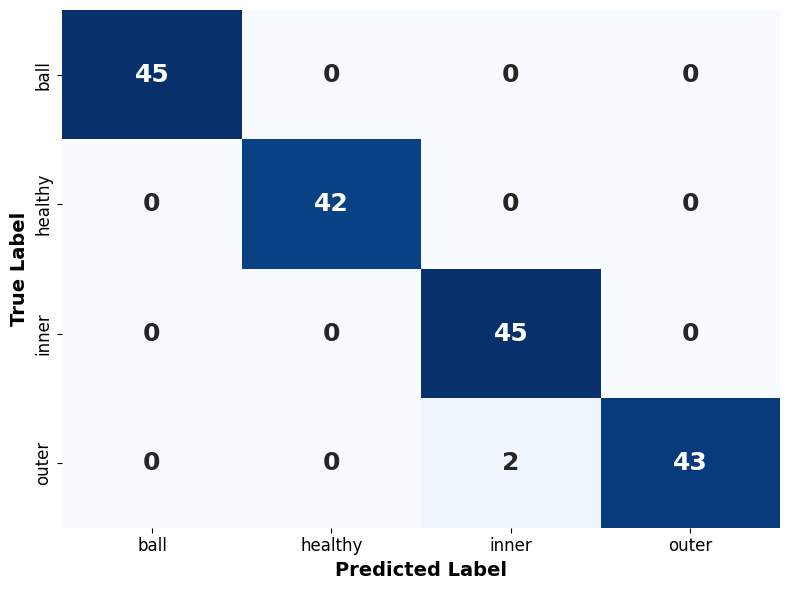

✅ Confusion matrix saved at: F:\NeuTech\new_results\cm_val.png


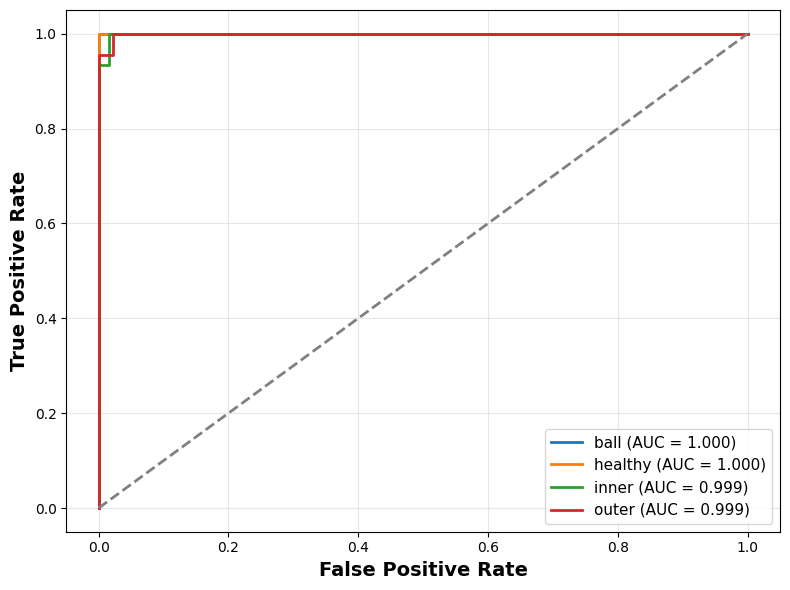

✅ ROC curves saved at: F:\NeuTech\new_results\roc_val.png


In [24]:
# Assuming you have: model, val_loader, cfg, and class names:
class_names = full_train.classes  # ['ball','healthy','inner','outer']

# Paths to save
cm_path  = os.path.join(cfg.output_dir, "cm_val.png")
roc_path = os.path.join(cfg.output_dir, "roc_val.png")

plot_confusion_matrix(model, val_loader, class_names, cfg.device, save_path=cm_path)
plot_roc_curves(model, val_loader, class_names, cfg.device, save_path=roc_path)


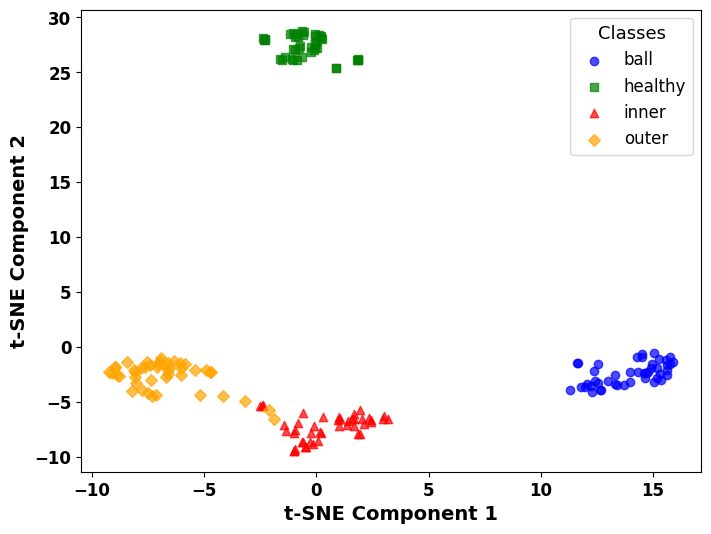

✅ t-SNE plot saved at: F:\NeuTech\new_results\tsne_features_vit.png


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ===============================================
# EXTRACT FEATURES FROM YOUR TRAINED MODEL
# ===============================================
@torch.no_grad()
def extract_features(model, dataloader, device):
    model.eval()
    all_features, all_labels = [], []

    for batch in dataloader:
        x = batch["pixel_values"].to(device)
        y = batch["labels"].to(device)

        # Generate band ids if model uses physics-aware attention
        if hasattr(model, "seq_len") and hasattr(model, "num_bands"):
            band_ids = torch.zeros(model.seq_len, dtype=torch.long)
            band_ids[1:] = torch.arange(model.seq_len - 1) % model.num_bands
            band_ids = band_ids.unsqueeze(0).repeat(x.size(0), 1).to(device)
            outputs = model.vit(x, output_hidden_states=True)
        else:
            outputs = model(x, output_hidden_states=True)

        # Extract CLS token embedding (last hidden state)
        cls_features = outputs.last_hidden_state[:, 0, :]  # [batch, hidden_dim]
        all_features.append(cls_features.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    features = np.concatenate(all_features, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return features, labels


# ===============================================
# COMPUTE t-SNE EMBEDDINGS (2D)
# ===============================================
def compute_tsne(features, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state, init='pca', perplexity=30)
    return tsne.fit_transform(features)


# ===============================================
# PLOT t-SNE RESULTS
# ===============================================
def plot_tsne(features_tsne, labels, class_names, save_path="tsne_vit_cwt.png"):
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red', 'orange']
    markers = ['o', 's', '^', 'D']

    for i, (cls, color, marker) in enumerate(zip(class_names, colors, markers)):
        mask = (labels == i)
        plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                    label=cls, color=color, marker=marker, alpha=0.7)

    plt.legend(title="Classes", fontsize=12, title_fontsize=13, loc='best', frameon=True)
    #plt.title("t-SNE of ViT Feature Space (2D)", fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
    plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    #plt.grid(alpha=0.3)

    plt.savefig(save_path, dpi=1000)
    plt.show()
    print(f"✅ t-SNE plot saved at: {save_path}")


# ===============================================
# MAIN EXECUTION
# ===============================================
device = cfg.device  # already set in your main training script
class_names = full_train.classes  # ['ball', 'healthy', 'inner', 'outer']

# Use your validation loader (or test loader if you have one)
features, labels = extract_features(model, val_loader, device)
features_2d = compute_tsne(features)
plot_tsne(features_2d, labels, class_names, save_path=os.path.join(cfg.output_dir, "tsne_features_vit.png"))
